In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client
from scipy.signal import savgol_filter
from config import preprocessed_dir, mask_dir, single_metric_dir, SNOW_YEAR, uncertainty_dir
from luts import snow_cover_threshold, inv_cgf_codes
from shared_utils import open_preprocessed_dataset, write_single_tile_xrdataset
from filter_and_fill import is_snow_valid_and_nonzero, is_low_illumination_for_solar_zenith

import matplotlib.pyplot as plt

client = Client()

tile_id = "h10v02"
fp = preprocessed_dir / f"snow_year_{SNOW_YEAR}_{tile_id}.nc"
snow_ds = open_preprocessed_dataset(
    fp, {"x": "auto", "y": "auto"}, "CGF_NDSI_Snow_Cover"
)
bitflag_ds = open_preprocessed_dataset(
    fp, {"x": "auto", "y": "auto"}, "Algorithm_Bit_Flags_QA"
)
bitflag_subset = bitflag_ds.isel(x=slice(6000, 6004), y=slice(1500, 1504))
snow_data = snow_ds.isel(x=slice(6000, 6004), y=slice(1500, 1504))
snow_ds.close()
bitflag_ds.close()
snow_valid_is_true = is_snow_valid_and_nonzero(snow_data)
low_illumination_is_true = is_low_illumination_for_solar_zenith(bitflag_subset)
value_to_filter_is_true = snow_valid_is_true & low_illumination_is_true
mask_data = value_to_filter_is_true > 0

In [4]:
def identify_sections(mask):
    """
    Identify continuous true sections in a mask array.
    
    Args:
        mask (np.array): 1D boolean array indicating where to apply the filter.
    
    Returns:
        list of slices: Each slice represents a section to filter.
    """
    true_indices = np.flatnonzero(mask)
    if true_indices.size == 0:
        return [] # avoid IndexError later on
    split_points = np.where(np.diff(true_indices) != 1)[0] + 1
    split_indices = np.concatenate([[0], split_points, [true_indices.size]])
    return [slice(true_indices[start], true_indices[end - 1]) for start, end in zip(split_indices[:-1], split_indices[1:])]


def filter_data(snow_data, sections_to_filter, window_length=5, polyorder=1):
    """
    Apply a Savitzky-Golay filter to specified sections of data.
    
    Args:
        snow_data (np.array): 1D array of snow cover data to filter.
        sections_to_filter (list of slices): Sections of the data array to filter.
        window_length (int): The length of the filter window (number of coefficients). window_length must be a positive odd integer.
        polyorder (int): The order of the polynomial used to fit the samples. polyorder must be less than window_length.
    
    Returns:
        np.array: The filtered data.
    """
    filtered_data = snow_data.copy()
    for section in sections_to_filter:
        print(section.stop)
        if (section.stop - section.start) < window_length:
            # Skip filtering for sections smaller than the window length
            continue
        filtered_data[section] = 199
        #filtered_data[section] = savgol_filter(snow_data[section], window_length, polyorder)
    return filtered_data


def fill_obscured_values_with_adjacent_observations(snow_data, sections_to_fill):
    """
    Fill missing observations (cloud, night) with adjacent valid observations using the median time index of the obscured period as the midpoint in the filling step-function.
    
    Args:
        snow_data (np.array): 1D array of snow cover data to fill.
        sections_to_fill (list of slices): Sections of the data array to fill.
    
    Returns:
        np.array: The filled data.
    """
    filled_data = snow_data.copy()
    for section in sections_to_fill:
        last_valid_before = snow_data[section.start - 1]
        
        # get first valid observation after obscured period is over
        first_valid_after = snow_data[section.stop + 1]

        # get median index (halfway point) of the obscured period
        halfway_point = (section.start + section.stop) // 2
            
        # fill first half of obscured period with last valid observation before obscured onset
        filled_data[section.start : halfway_point] = (last_valid_before)
        
        # fill second half of obscured period with first valid observation afterward        
        filled_data[halfway_point : section.stop + 1] = (first_valid_after)
    
    return filled_data


def construct_result(original_data, modified_data, mask):
    """
    Combine modified and original data based on the mask.
    
    Args:
        original_data (np.array): The original data array.
        modified_data (np.array): The filtered data array.
        mask (np.array): The mask array indicating filtered sections.
    
    Returns:
        np.array: The combined data array.
    """
    result = np.where(mask, modified_data, original_data)
    return result


def apply_filter_and_fill_to_masked_sections(snow_data, mask_data, window_length=3, polyorder=1):
    
    def filter_section(data, filter_mask):
        sections_to_filter = identify_sections(filter_mask)
        filtered_data = filter_data(data, sections_to_filter, window_length, polyorder)
        return construct_result(data, filtered_data, filter_mask)

    def fill_section(data, obscured_mask):
        sections_to_filter = identify_sections(obscured_mask)
        filled_data = fill_obscured_values_with_adjacent_observations(data, sections_to_filter)
        return construct_result(data, filled_data, obscured_mask)

    # first pass the Savitzky-Golay filter over the low illumination observations
    filtered_snow_data = xr.apply_ufunc(
        filter_section, 
        snow_data, 
        mask_data, 
        input_core_dims=[['time'], ['time']], 
        output_core_dims=[['time']], 
        vectorize=True, 
        dask='parallelized', 
        output_dtypes=[snow_data.dtype]
    )
    return filtered_snow_data
    
    # # next forward/backward fill the night period
    # night_filled_snow_data = xr.apply_ufunc(
    #     fill_section, 
    #     filtered_snow_data, 
    #     filtered_snow_data == inv_cgf_codes["Night"], 
    #     input_core_dims=[['time'], ['time']], 
    #     output_core_dims=[['time']], 
    #     vectorize=True, 
    #     dask='parallelized', 
    #     output_dtypes=[np.int8]
    # )

    # # finally, forward/backward fill the cloud period
    # cloud_filled_snow_data = xr.apply_ufunc(
    #     fill_section, 
    #     night_filled_snow_data, 
    #     night_filled_snow_data == inv_cgf_codes["Cloud"], 
    #     input_core_dims=[['time'], ['time']],
    #     output_core_dims=[['time']],
    #     vectorize=True, 
    #     dask='parallelized', 
    #     output_dtypes=[np.int8]
    # )
    # return cloud_filled_snow_data


filtered_and_filled_data = apply_filter_and_fill_to_masked_sections(snow_data, mask_data, window_length=5, polyorder=1).compute()
filtered_and_filled_data.name = "CGF_NDSI_Snow_Cover"
filtered_and_filled_data

<xarray.DataArray 'CGF_NDSI_Snow_Cover' (y: 4, x: 4, time: 366)>
array([[[  0,   0, 237, ...,   0,   0,   0],
        [  0,   0, 237, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[237, 237, 237, ..., 237, 237, 237],
        [  0,   0,   0, ..., 237, 237, 237],
        [  0,   0,   0, ..., 237, 237, 237],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[237,   0,   0, ...,   0,   0,   0],
        [237,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-01 2015-08-02 ... 2016-07-31
  * x        (x) float64 -160.0 -160.0 -160.0 -160.0
  * y        (y) float64 65.0 65.01 65.01 65.01

In [ ]:
client.close()

In [ ]:
help(write_single_tile_xrdataset)

In [ ]:
write_single_tile_xrdataset(filtered_and_filled_data, tile_id, "filtered_filled")

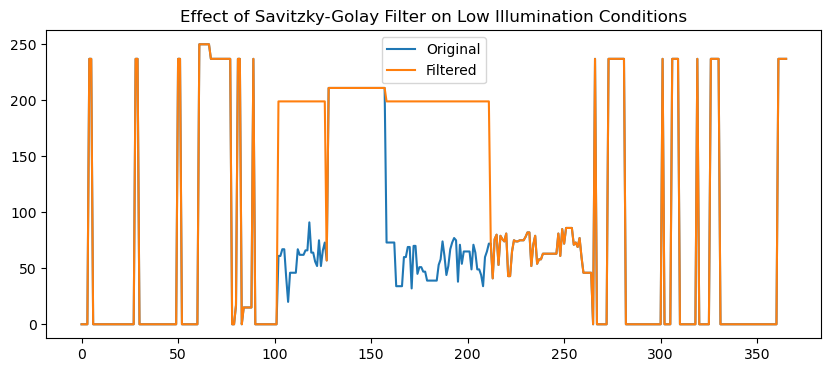

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(snow_data.isel(x=1,y=1), label='Original')
plt.plot(filtered_and_filled_data.isel(x=1,y=1), label='Filtered')
plt.legend()
plt.title(f'Effect of Savitzky-Golay Filter on Low Illumination Conditions')
plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(snow_data.isel(x=3,y=3), label='Original')
# plt.plot(filtered_and_filled_data.isel(x=3,y=3), label='Filtered')
# plt.legend()
# plt.title(f'Effect of Savitzky-Golay Filter on Low Illumination Conditions')
# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#time = single_xy_snow_test.time.values
snow_subset.isel(x=1, y=1).plot(ax=ax, label='Original', alpha=0.25)
savgol_result.isel(x=1, y=1).compute().plot(ax=ax, label='Filtered', alpha=0.5)
#filtered_nightfill_datacube.isel(x=1,y=1).compute().plot(ax=ax, label='Filtered + Night Filled', alpha=0.75)
#filtered_cloudfill_datacube.isel(x=1,y=1).compute().plot(ax=ax, label='Filtered + Cloud & Night Filled')
#ax.fill_between(time, 0, 1, where=single_xy_mask_test, color='gray', alpha=0.3, transform=ax.get_xaxis_transform())
ax.set_ylabel("VIIRS CGF_NDSI_Snow_Cover Value")
plt.legend()
plt.show()

In [ ]:
# maybe transpose?
